In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as sps

drive.mount("/content/drive")

#warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

Mounted at /content/drive


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### 1. Реализация байесовского FC-слоя с возможностью контролировать ранг.

Линейный слой задается формулой 
$$
\mathbf{f}(\mathbf{x}) = \mathbf{W} \mathbf{x} + \mathbf{b}, \mathbf{x} \in \mathbb{R}^{n}, \mathbf{W} \in \mathbb{R}^{m \times n}, \mathbf{b} \in \mathbb{R}^m
$$.

$$
\mathbf{W} = \begin{pmatrix}
\mathbf{w_1}^T\\
\mathbf{w_2}^T\\
\dots\\
\mathbf{w_m}^T
\end{pmatrix}, \ \mathbf{w}_i \in \mathbb{R}^{n} - {нейроны}
$$

Таким образом слой имеет $m$ нейронов.


Мы считаем, что 
$$
\mathbf{w}_i \sim \mathcal{N}(\mathbf{\mu}_i, \mathbf{\Sigma}_i), \ i \in [1, \dots, m]; \mathbf{\mu}_i \in \mathbb{R}^{n}, \mathbf{\Sigma}_i \in \mathbb{R}^{n \times n} .
$$

Обучаемые параметры - это $\mathbf{W}_i, \mathbf{\mu}_i$. 

На каждый forward pass мы генерируем параметры из распределения и используем их для forward.

Чтобы градиенты проходили, используем reparametrization trick.

Паарметризация матриц:
$$
\mathbf{\Sigma_i} = A_iA_i^T, \ A_i \in \mathbb{R}^{n \times h}, \ h \le n
$$

Такой парамтеризацией добиваемся что $\mathbf{\Sigma}_i \in \mathbb{S}^n_{+}$. ТАкми образом мы модем контролировать ранг матрицы $\mathbf{\Sigma_i}$ и ее внутреннюю структуру (хотим блочно-диагональную)

Также мы будем хранить не матрицу $A$, а ее $\log$ (ЗАЧЕМ???)

**Генерация:**
1. 
$$
\mathbf{\varepsilon }_i \sim \mathcal{N}(0, I)
$$

2. 
$$
\mathbf{w}_i = \mathbf{\mu}_i + A_i \cdot \mathbf{\varepsilon}_i
$$

3. Таким образом получаем:

$$
\mathbf{W} = \begin{pmatrix}
(\mathbf{\mu}_1 + A_1 \cdot \mathbf{\varepsilon}_1)^T\\
(\mathbf{\mu}_2 + A_2 \cdot \mathbf{\varepsilon}_2)^T\\
\dots \\
(\mathbf{\mu}_m + A_m \cdot \mathbf{\varepsilon}_m)^T
\end{pmatrix} =
\begin{pmatrix}
\mathbf{\mu}_1^T\\
\mathbf{\mu}_2^T\\
\dots \\
\mathbf{\mu}_m^T\\
\end{pmatrix} + \begin{pmatrix}
(A_1\mathbf{\varepsilon}_1)^T\\
(A_2\mathbf{\varepsilon}_2)^T\\
\dots \\
(A_m\mathbf{\varepsilon}_m)^T\\
\end{pmatrix}
$$


Bias в нейросети считаем неслучайным.

Вопросы:

1. Чем заполнять матрицы ковариаций? Чтобы взрыва не было???
2. Чем заполтнять mu? -> Uniform(-sqrt(features), ...)
3. НЕ СКЛАДЫВАТЬ $A_i$ в одно матрицу (иначе по ней всей потекут градиенты)

Линейный слой вычисляет
$$
y = xA^T + b
$$

In [ ]:
class BayesLinear(nn.Module):
    '''
        It realizes bayesian NN:

        f(x) = Ax + b
        A \sim N(0, \Sigma)
        b = mu

        In real we save only B: BB^T=A
    '''
    def __init__(self, in_features, out_features, hidden_dim=None, bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias

        n = in_features
        m = out_features

        # torch.nn.init.xavier_uniform

        self.mu_s = nn.Parameter(nn.init.xavier_uniform_(torch.zeros(size=(m, n)))) # [out, int]
        if hidden_dim == None:
            AA = [torch.empty(size=(n, n)) for i in range(m)]
            
            for i in range(len(AA)):
                nn.init.xavier_uniform_(AA[i])
                AA[i] /= np.sqrt(n)
            
            self.A_s = nn.ParameterList([
                                    nn.Parameter(AA[i]) for i in range(m)
                                    ])
        else:
            raise Exception("no realization of hidden")

        # self.H = nn.Parameter(torch.block_diag(*A_s)) # [in*out, in*out]

        if self.bias:
            self.b = nn.Parameter(torch.empty(size=(m, )))
            bound = 1 / np.sqrt(self.out_features)
            nn.init.uniform_(self.b, -bound, bound)
        else:
            self.b = None

    def generate_epsilons(self):
        '''
            generates the vestor E of size [in_features x out_features, 1] of N(0, 1)
        '''
        device = self.mu_s.device
        return torch.from_numpy(sps.norm.rvs(size=(self.out_features, self.in_features))).float().to(device)

    def generate_W(self):
        epsilons = self.generate_epsilons() # [out, in]
        # H = torch.block_diag(*self.A_s)
        H_x_epsilon = torch.empty(size=(self.out_features, self.in_features), device=self.mu_s.device)# [out, in]

        for i in range(self.out_features):
            # print(self.A_s[i].shape, epsilons[i])
            H_x_epsilon[i] = torch.matmul(self.A_s[i], epsilons[i])
        
        return self.mu_s + H_x_epsilon # [out, in]

    
    def forward(self, input):
        '''
            batch = [*, in_features]
        '''

        if self.training: # здесь генерируем 
            W = self.generate_W() # [out_features, in_features]
        else:
            W = self.mu_s # [out_features, in_features]
        # print(input.shape, W.shape)
        return F.linear(input, W, self.b)


class NN_2_bayes(nn.Module):
    def __init__(self, in_len, hid_dim, out_len):
        '''
            2-х слойная полносвязная сеть без ортогонализации
            Linear->ReLU->Linear
        '''
        super().__init__()

        # One line suffices: Instantiate a linear layer with orthonormal columns
        self.W1 = BayesLinear(in_len, hid_dim, bias=True)
        self.act1 = nn.ReLU()
        self.W2 = BayesLinear(hid_dim, out_len, bias=True)
        self.act2 = nn.Identity()

    def forward(self, x):
        # self.linear is orthogonal and every 3x3 kernel in self.cnn is of rank 1
        x = self.W1(x)
        x = self.act1(x)

        x = self.W2(x)
        x = self.act2(x)

        return x

### 2. Эксперимент

#### 2.1. Скачивание и распаковка датасета.

In [ ]:
!git clone https://github.com/mmalekzadeh/motion-sense.git

Cloning into 'motion-sense'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 612 (delta 4), reused 4 (delta 4), pack-reused 605
Receiving objects: 100% (612/612), 201.77 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (296/296), done.


разархивируем в content все его части (также есть на моем гугл-диске по адресу /content/drive/MyDrive/metric_analysis/datasets/motion-sense) (/content/)

In [ ]:
!cp /content/motion-sense/data/data_subjects_info.csv -d .
!unzip -q /content/motion-sense/data/A_DeviceMotion_data.zip -d .
!unzip -q /content/motion-sense/data/B_Accelerometer_data.zip -d .
!unzip -q /content/motion-sense/data/C_Gyroscope_data.zip -d .

In [ ]:
# !cp /content/motion-sense/data/* /content/drive/MyDrive/metric_analysis/datasets/motion-sense
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/A_DeviceMotion_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/B_Accelerometer_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/
# !unzip -q /content/drive/MyDrive/metric_analysis/datasets/motion-sense/C_Gyroscope_data.zip -d /content/drive/MyDrive/metric_analysis/datasets/motion-sense/

Из датасета с большим количеством измерений берем только "userAcceleration" во время ходьбы "wlk"

In [ ]:
freq = 50 # частота замера = 50ГЦ

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration"] # attitude, gravity, rotationRate, userAcceleration
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ["wlk"] # ACT_LABELS [2:3]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
print(dt_list)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['userAcceleration']
[INFO] -- Selected activites: ['wlk']
[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(344288, 10)


,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,0.091702,0.415881,0.093689,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,0.367412,0.004566,-0.106082,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,0.172093,-0.217483,-0.163387,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,0.004957,-0.237566,-0.019080,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,-0.040292,-0.241461,0.015201,0.0,0.0,102.0,188.0,46.0,1.0,7.0


Возьмем userAcceleration по x-y для id=0.0 (первый участник) и далее будем использовать его


In [ ]:
first_user_data = dataset[dataset['id'] == 0.0]
first_user_data

In [ ]:
first_user_data.describe()

#### 2.2 Применение обычной сети, замер качества

In [ ]:
!pip install geotorch -q

from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

period = 2 # 2 секунды мы даем на вход модели

steps_in_time = period * freq # сколько моментов времени в периуде
print(steps_in_time)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.6 MB/s eta 0:00:00
100


In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=3e-4) # L2-regularization
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cuda:0


In [ ]:
torch.optim.SGD?

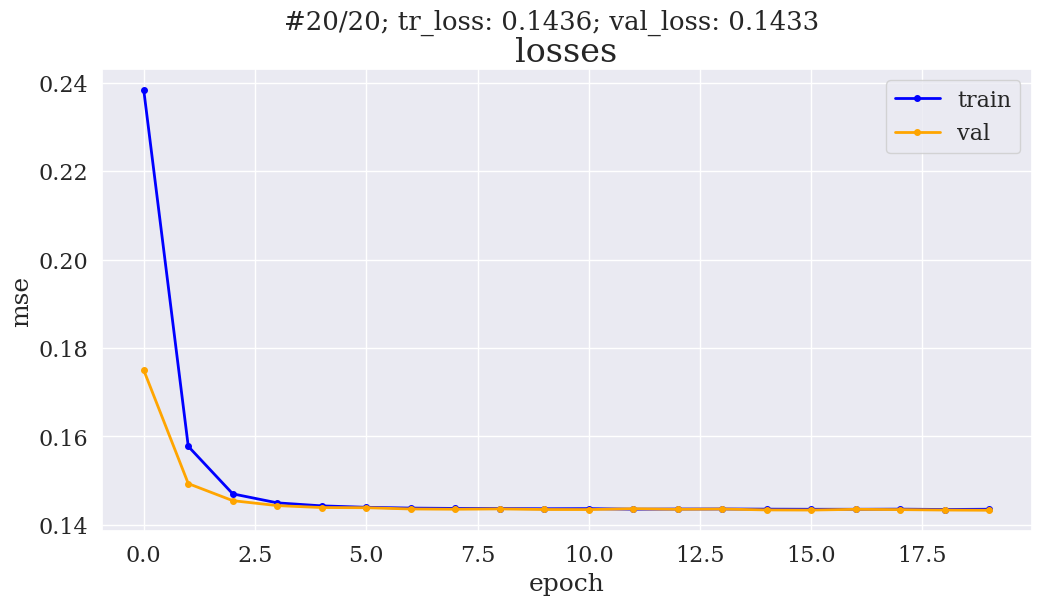

In [ ]:
model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=20,
    draw_every=1,
    separate_show=False,
    device=device
)

In [ ]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device)

#### 2.3 теперь тренируем байесовскую сеть с такой же архитектурой

In [ ]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model, dataset, batch_size, vis_time=10, device=device,
                         gen_type='train')

In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-1

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

bayes_model = NN_2_bayes(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

cuda:0


In [ ]:
for name, par in bayes_model.named_parameters():
    print(name, par.shape, par.requires_grad)

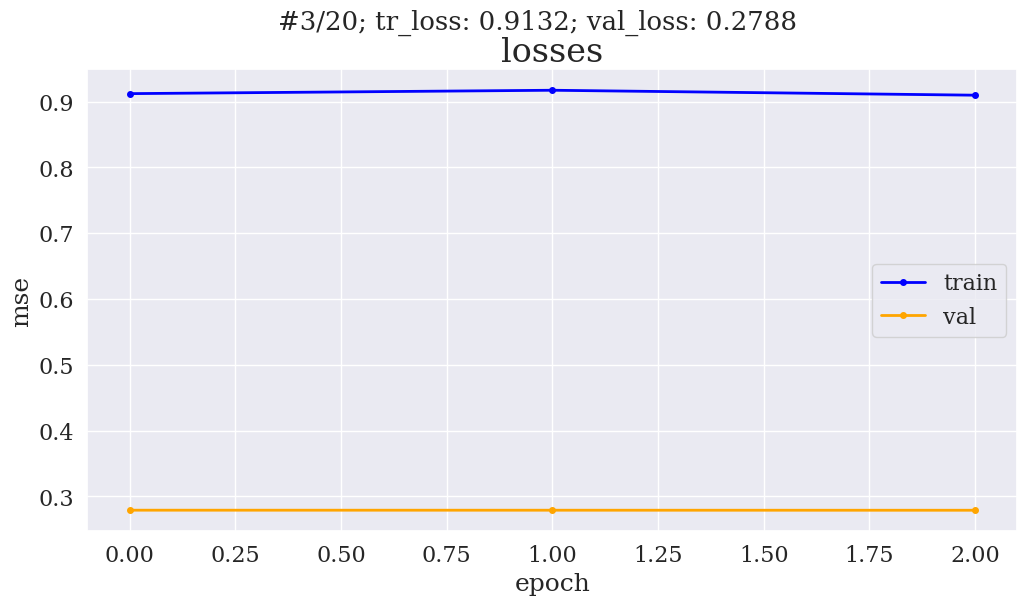

KeyboardInterrupt: ignored

In [ ]:
bayes_model, optimizer, losses = learning_loop(
    model = bayes_model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=20,
    draw_every=1,
    separate_show=False,
    device=device
)

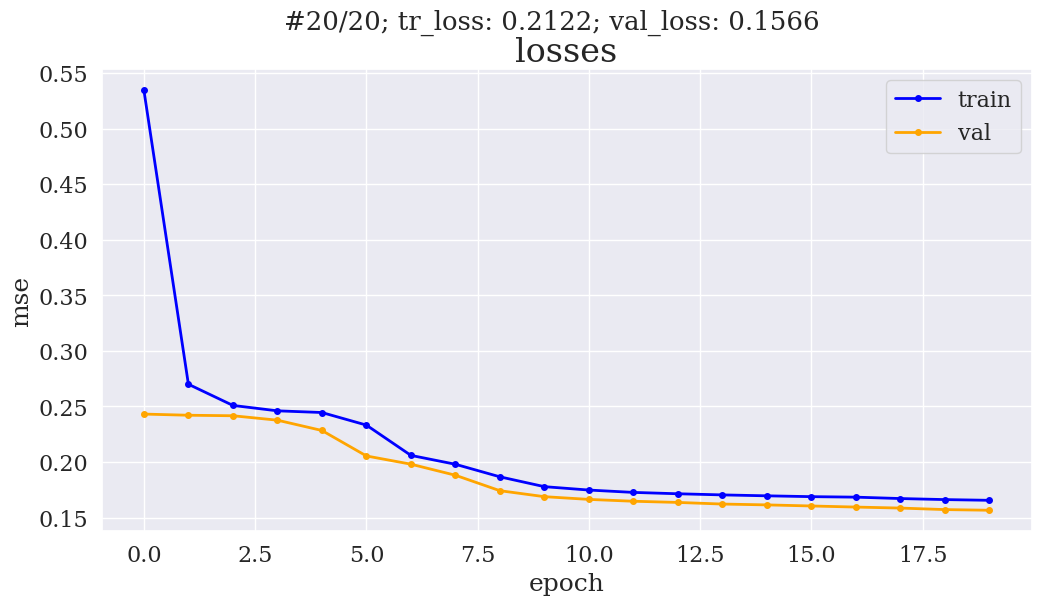

In [ ]:
model_bayes, optimizer, losses = learning_loop(
    model = model_bayes,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=20,
    draw_every=1,
    separate_show=False,
    device=device
)

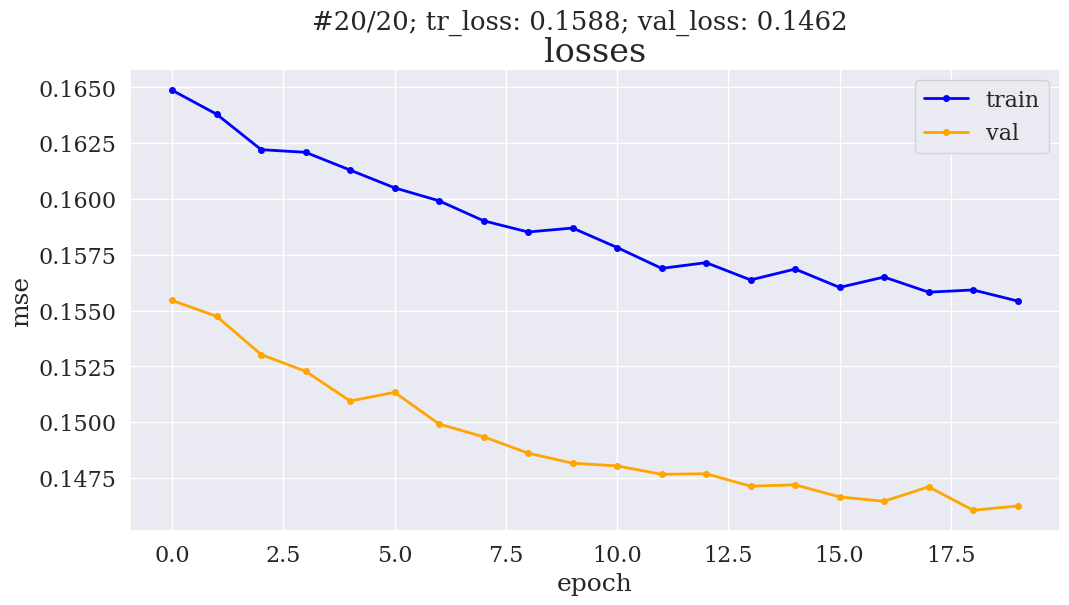

In [ ]:
model_bayes, optimizer, losses = learning_loop(
    model = model_bayes,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs=20,
    draw_every=1,
    separate_show=False,
    device=device
)

In [ ]:
x_acc = first_user_data['userAcceleration.x']
sec_times = np.arange(len(x_acc)) / freq

visualize_predictions_go(sec_times, first_user_data['userAcceleration.x'], model_bayes, dataset, batch_size, vis_time=10, device=device,
                         gen_type='train')

In [ ]:
14 / freq

0.28

In [ ]:
!mkdir /content/drive/MyDrive/metric_analysis/bayes_models
torch.save(model_bayes.state_dict(), "/content/drive/MyDrive/metric_analysis/bayes_models/model_100_3_100_20epoch")

#### Загрузка модели

In [ ]:
in_len = steps_in_time
hid_dim = 3
out_len = steps_in_time

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, 
                               out_len=out_len, 
                               s_noice=first_user_data['userAcceleration.x'], 
                               s_true=None)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

bayes_model = NN_2_bayes(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold=0.001, verbose=True)

bayes_model.load_state_dict(torch.load('/content/drive/MyDrive/metric_analysis/bayes_models/model_100_3_100_20epoch'))

In [ ]:
W_2_s = np.array([bayes_model.W2.A_s[i].detach().cpu().numpy() for i in range(len(bayes_model.W2.A_s))])
mu_2_s = bayes_model.W2.mu_s.detach().cpu().numpy()

In [ ]:
W_2_s.shape

(100, 3, 3)

In [ ]:
W_2_s.transpose((0, 2, 1)).shape

(100, 3, 3)

In [ ]:
covs = np.matmul(W_2_s, W_2_s.transpose((0, 2, 1)))
print(covs.shape)

(100, 3, 3)


In [ ]:
covs[3]

array([[ 4.7229576e-05,  2.7557473e-06, -1.8905263e-05],
       [ 2.7557473e-06,  1.8077740e-06, -4.0629498e-06],
       [-1.8905263e-05, -4.0629498e-06,  4.3952907e-05]], dtype=float32)

In [ ]:
plot_cov_heatmap(W_2_s[:25])

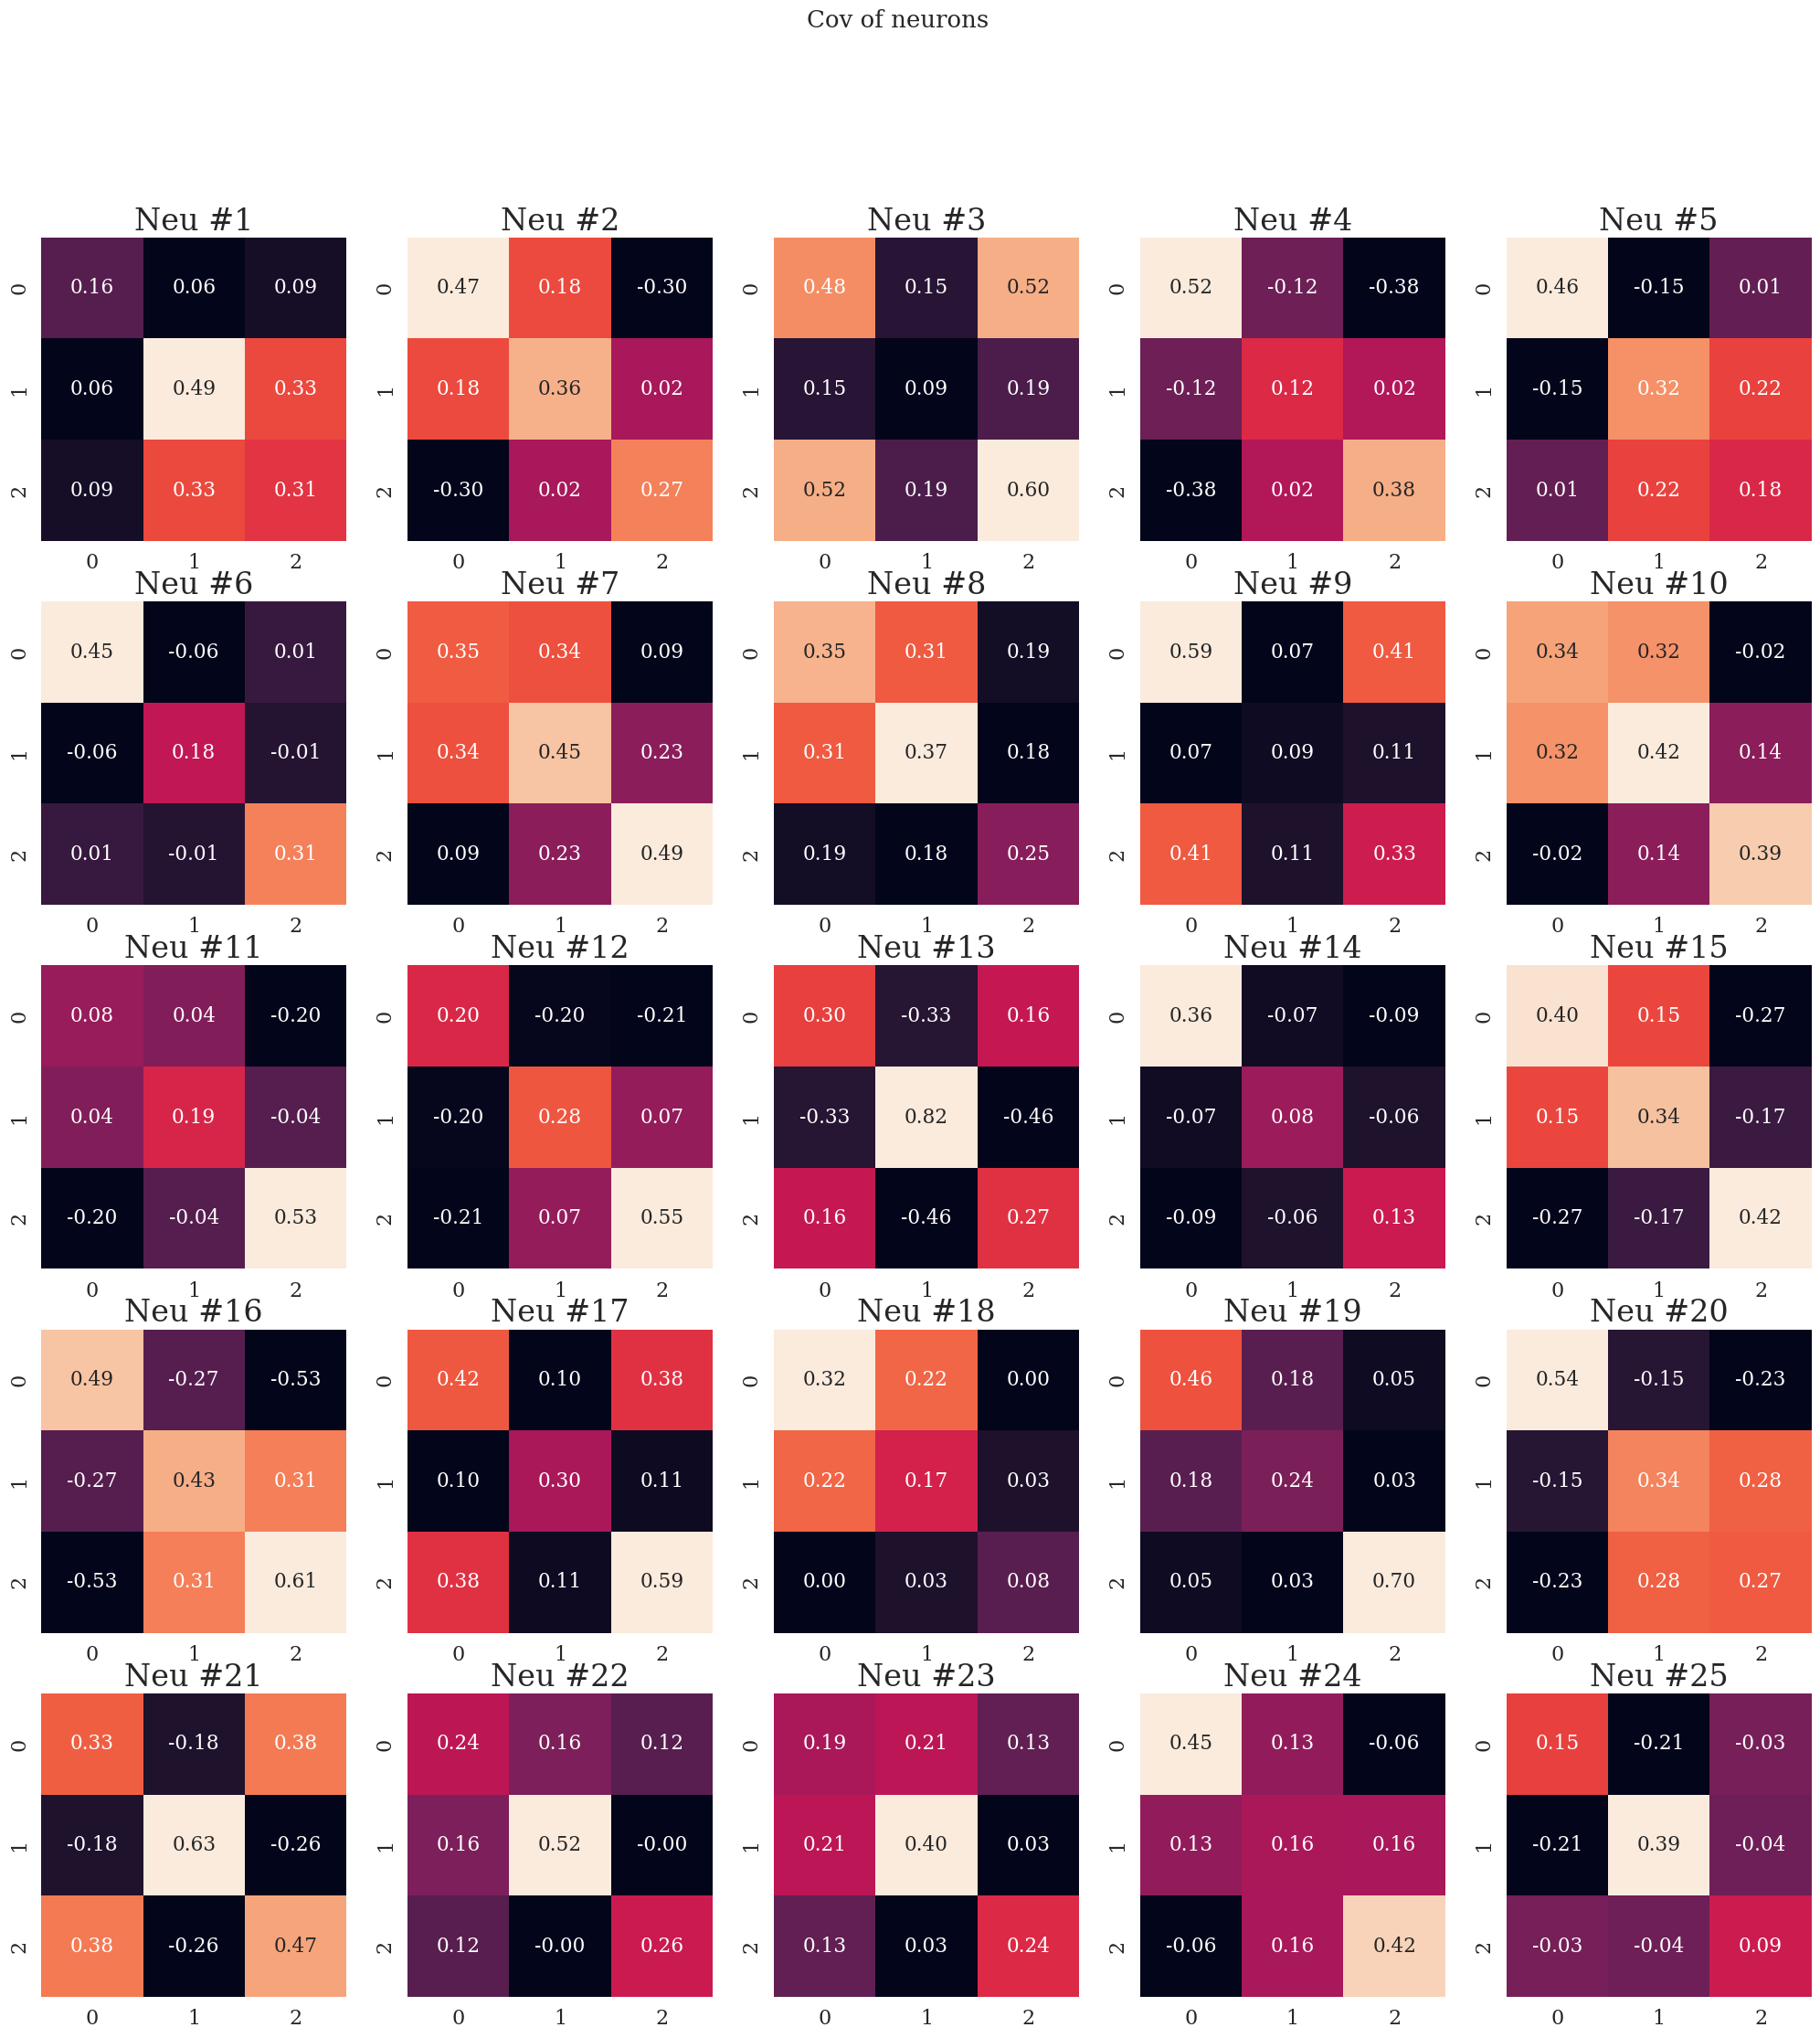

In [ ]:
plot_cov_heatmap(covs[:25])

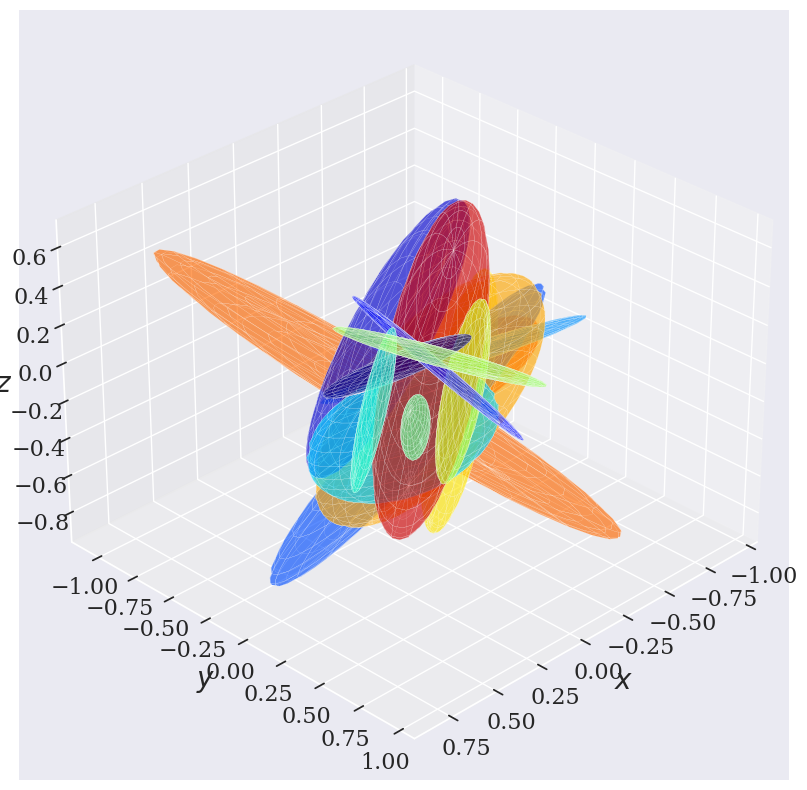

In [ ]:
plot_3d_gaussians(mu_2_s[:15], covs[:15], alpha=1)

### 2.4 Теперь визуализируем матрицы ковариаций нейронов

In [ ]:
model_bayes = NN_2_bayes(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)

model_bayes.load_state_dict(torch.load("/content/drive/MyDrive/metric_analysis/bayes_models/model_100_3_100_20epoch"))

<All keys matched successfully>

In [ ]:
W_2_s = np.array([model_bayes.W2.A_s[i].detach().cpu().numpy() for i in range(len(model_bayes.W2.A_s))])
mu_2_s = model_bayes.W2.mu_s.detach().cpu().numpy()

covs = np.matmul(W_2_s, W_2_s.transpose((0, 2, 1)))

In [ ]:
W_2_s.shape

(100, 3, 3)

In [ ]:
np.linalg.eig(covs[0])[0]

array([9.9873214e-05, 3.9223994e-07, 7.9527763e-06], dtype=float32)

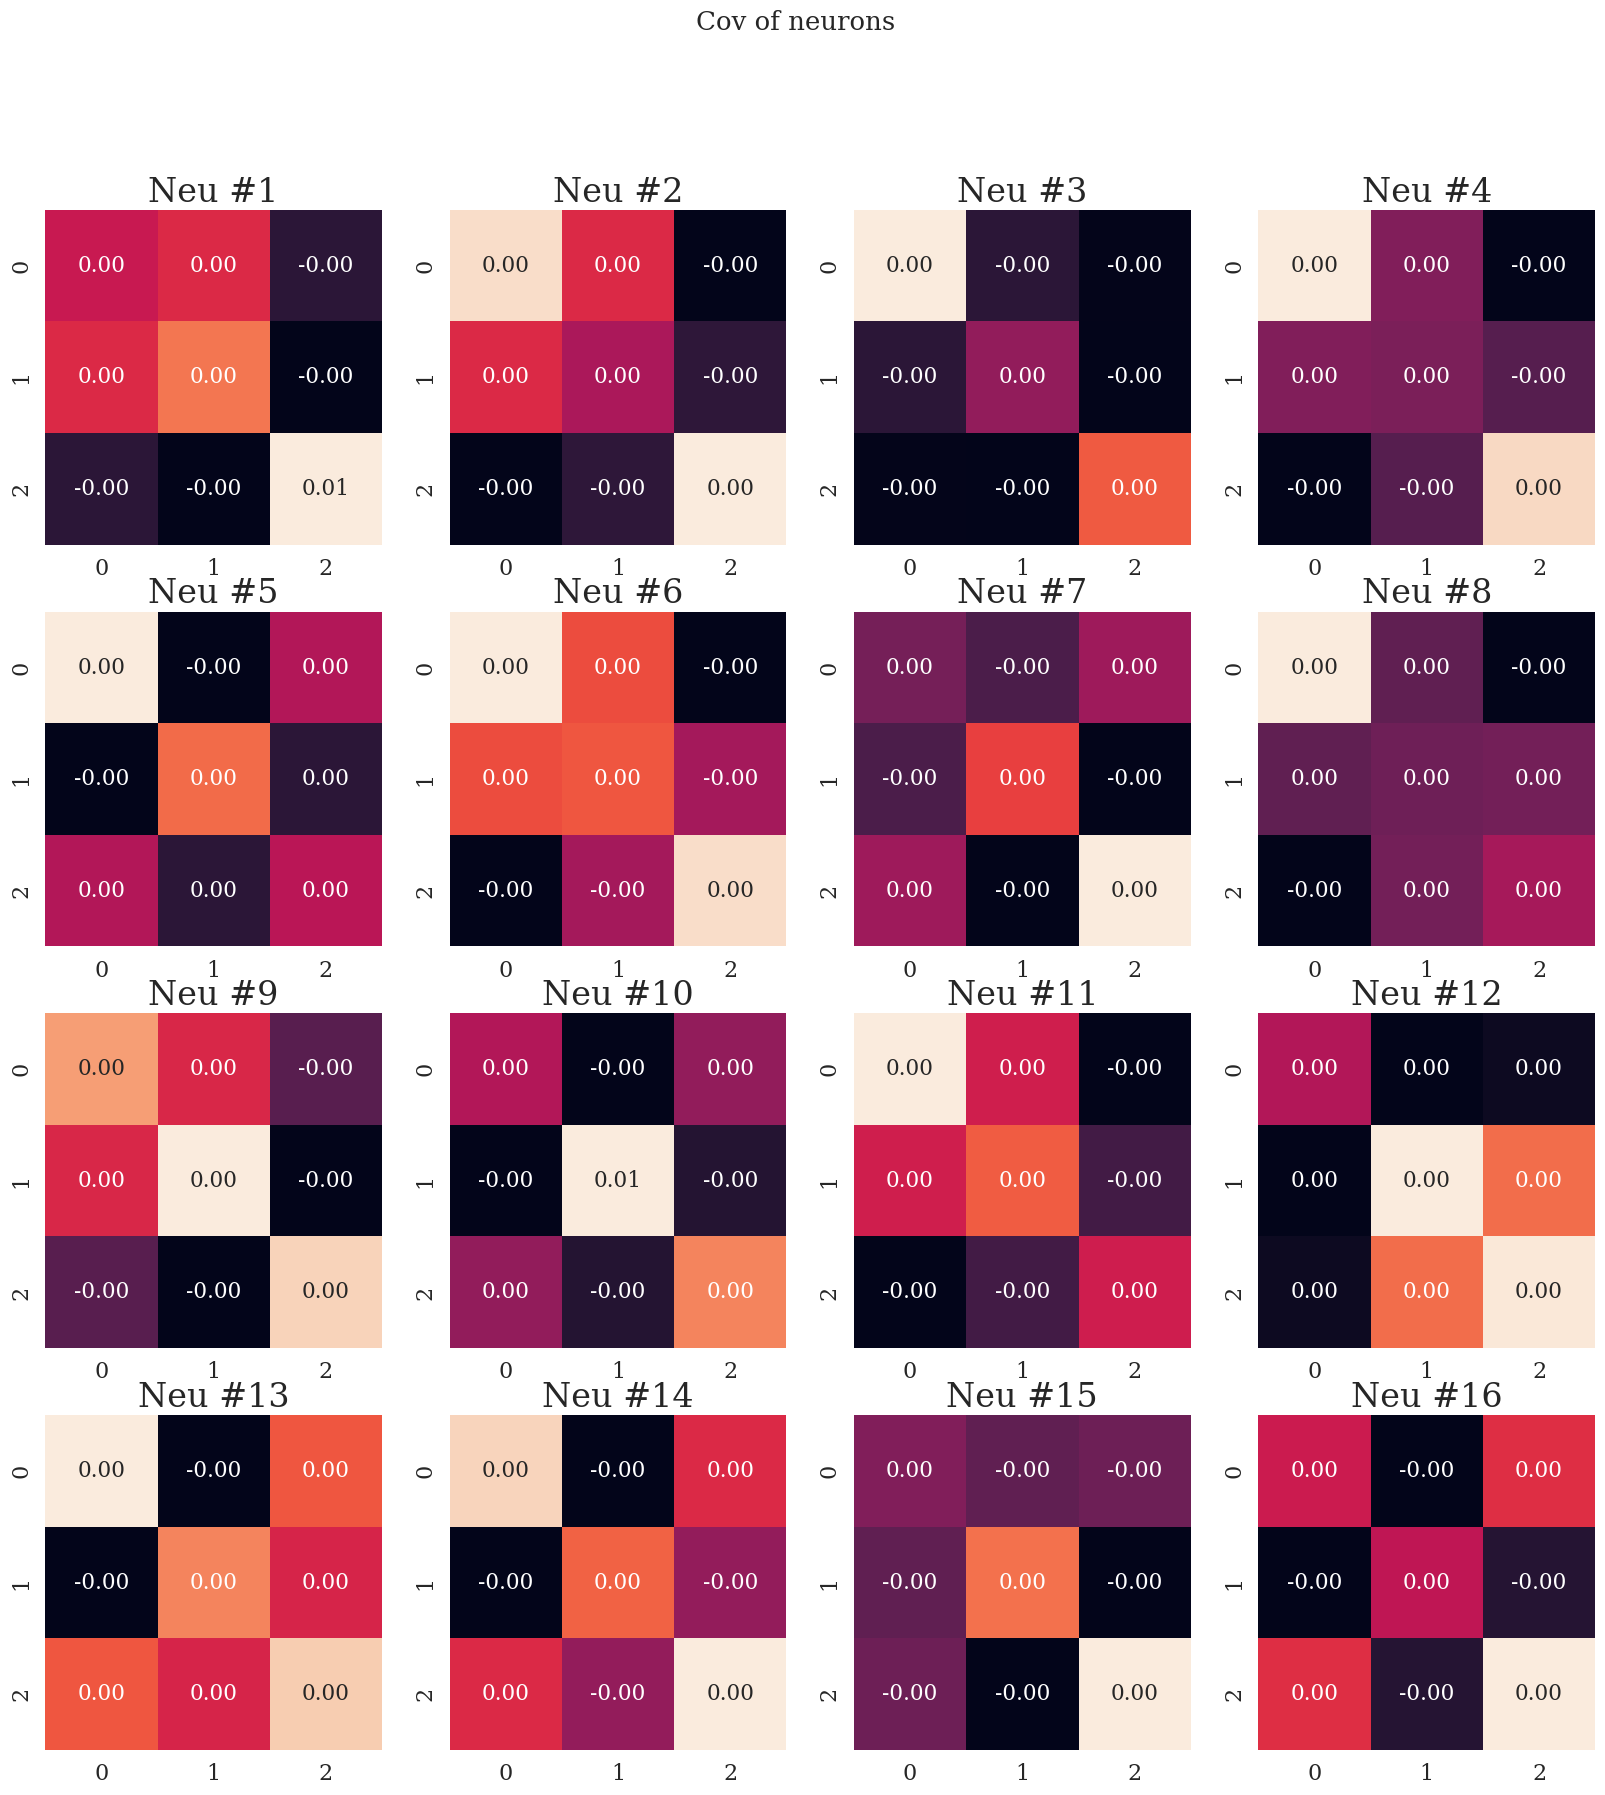

In [ ]:
plot_cov_heatmap(covs[:16]*100)

In [ ]:
plot_cov_heatmap(covs[:25], path_to_save='/content/drive/MyDrive/metric_analysis/plots/bayes_100_3_100', 
                  img_name='bayes_var')

In [ ]:
W_2_s[0]

array([[ 3.2338852e-03, -9.8994363e-04,  5.1640166e-04],
       [ 5.7087899e-03,  1.1361324e-03, -5.4256110e-05],
       [-7.2350889e-03,  3.1798589e-03,  4.1414585e-04]], dtype=float32)

In [ ]:
covs[0]

array([[ 1.1704673e-05,  1.7308847e-05, -2.6331461e-05],
       [ 1.7308847e-05,  3.3884025e-05, -3.7713329e-05],
       [-2.6331461e-05, -3.7713329e-05,  6.2629530e-05]], dtype=float32)

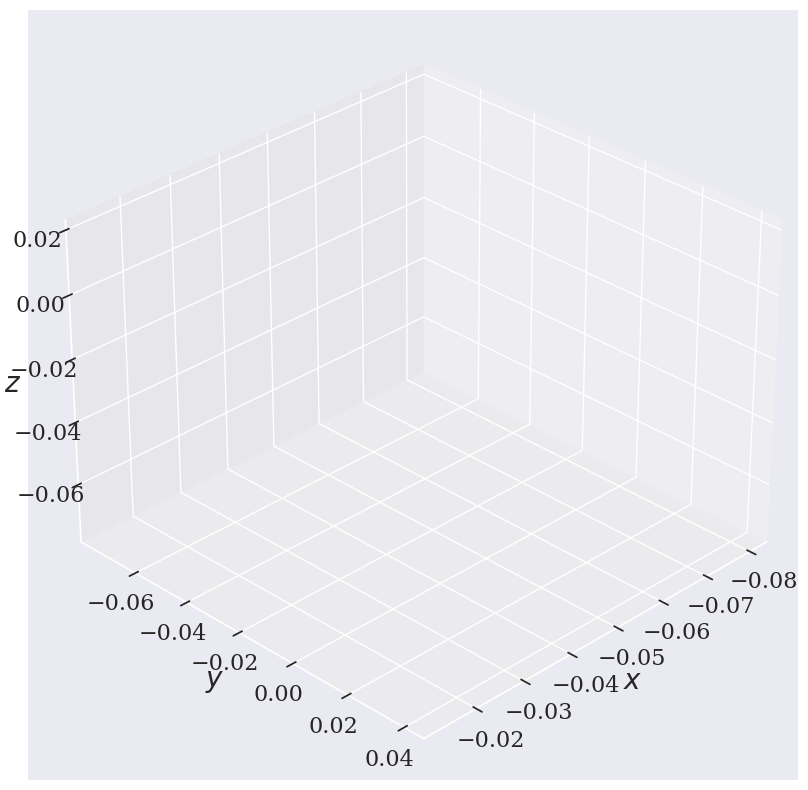

In [ ]:
plot_3d_gaussians(mu_2_s[:15], covs[:15], alpha=1)

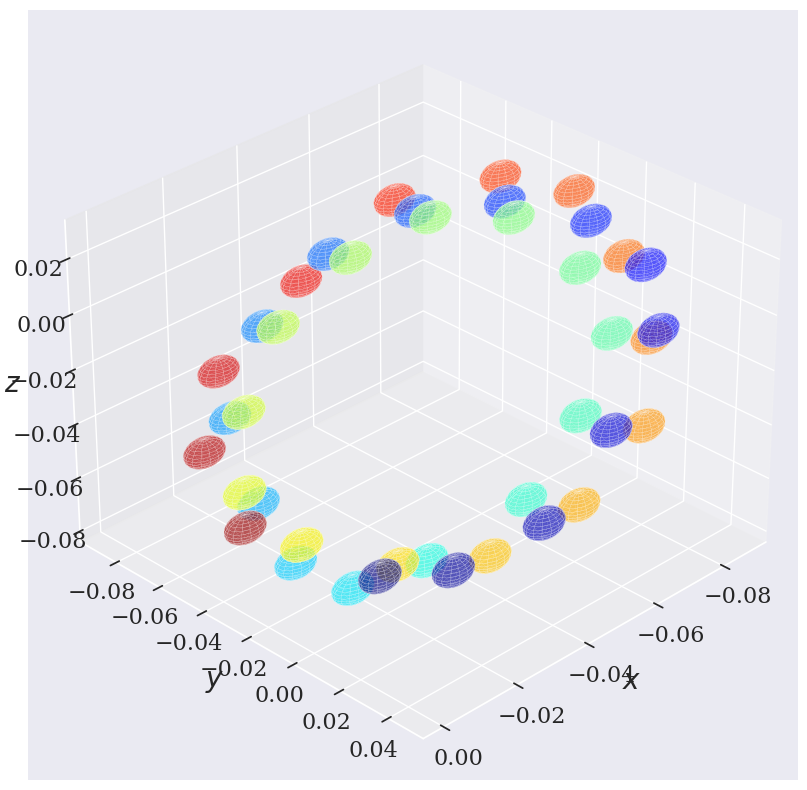

In [ ]:
plot_3d_gaussians(mu_2_s[:40], [np.eye(3) / 200] * 40, alpha=1)

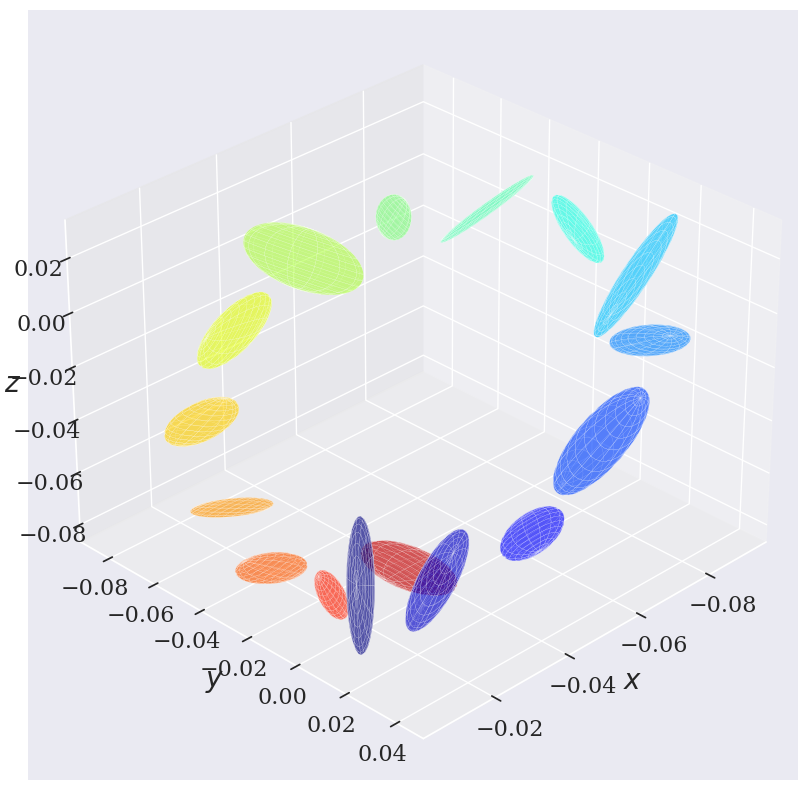

In [ ]:
plot_3d_gaussians(mu_2_s[:16], W_2_s[:16], alpha=2,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/bayes_100_3_100', 
                  img_name='3d_var_100_3_100_alpha=2')

In [ ]:
plot_3d_gaussians_rot(mu_2_s[:16], W_2_s[:16], alpha=3)

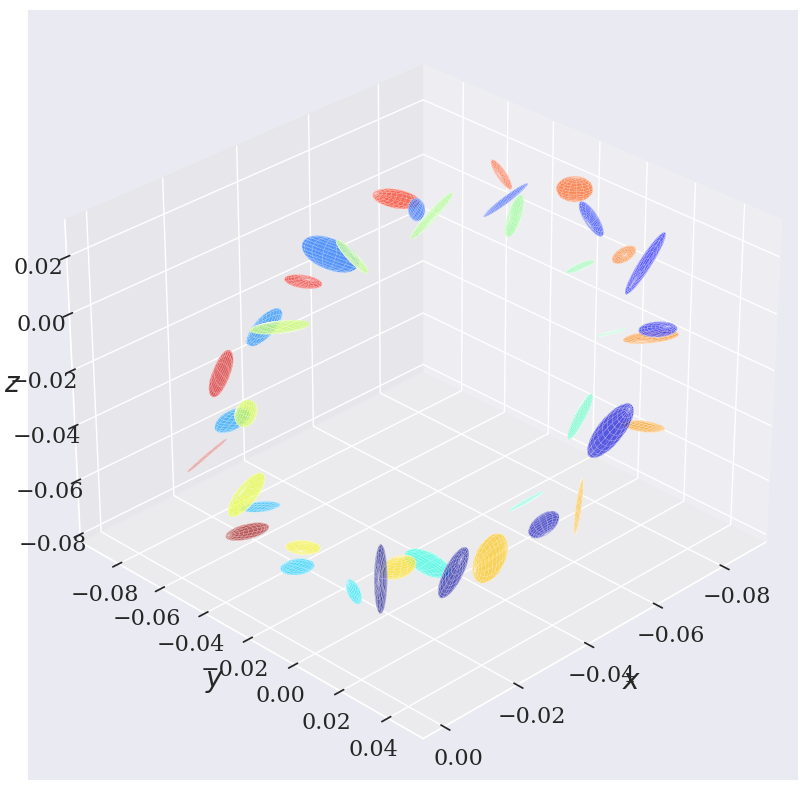

In [ ]:
plot_3d_gaussians(mu_2_s[:40], W_2_s[:40], alpha=1,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/bayes_100_3_100', 
                  img_name='3d_var_100_3_100_alpha=1')

In [ ]:
plot_3d_gaussians(mu_2_s[:40], W_2_s[:40], alpha=3,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/bayes_100_3_100', 
                  img_name='3d_var_100_3_100_alpha=3')

In [ ]:
plot_3d_gaussians_rot(mu_2_s[:40], W_2_s[:40], alpha=1, path_to_save='/content/drive/MyDrive/metric_analysis/plots/bayes_100_3_100', 
                  img_name='3d_var_100_3_100_alpha=1')

In [ ]:
plot_3d_gaussians_rot(mu_2_s[:5], W_2_s[:5], alpha=1)

In [ ]:
plot_cov_heatmap(variances, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_20_3_20_normal')

### 3. Эксперимент 2: более сложная архитектура

Вопросы:

1. Что такое KL-criterion для модели?